In [2]:
import iris
import numpy as np
import os
from pyproj import Proj, transform
import sys
import warnings
import cartopy.crs as ccrs
import iris.analysis.cartography
warnings.filterwarnings("ignore")

root_fp = "/nfs/a319/gy17m2a/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'PhD/Scripts/DataProcessing/Regridding')
from Regridding_functions import *
# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

gb_gdf = create_gb_outline({'init' :'epsg:3857'})

def mask_cube(cube, gb_mask):
    masked_cube_data = cube * gb_mask[np.newaxis, :, :]

    # APPLY THE MASK
    reshaped_mask = np.tile(gb_mask, (cube.shape[0], 1, 1))
    reshaped_mask = reshaped_mask.astype(int)
    reversed_array = ~reshaped_mask.astype(bool)

    # Mask the cube
    masked_cube = iris.util.mask_cube(cube, reversed_array)
    
    return masked_cube

# Define BNG crs
bng_crs = ccrs.OSGB()

# Define rot pole
rotated_pole_crs2 = ccrs.RotatedPole(pole_longitude=177.5, 
                       pole_latitude=37.5,
                       # central_rotated_longitude=-106.0, 
                       globe = ccrs.Globe(semimajor_axis=6371229.0,
                                semiminor_axis=6371229.0))

### Get the mask
gb_mask_2km = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
gb_mask_12km_wgs84 = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_wgs84_GB_Mask.npy")
gb_mask_12km = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")

### The data I want to work with

In [7]:
file_model_2_2km ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/01/1980_2001/pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc'
cube_2km =iris.load_cube(file_model_2_2km)
cube_2km = cube_2km[0,:,:,:]
cube_2km = trim_to_bbox_of_region_regriddedobs(cube_2km, gb_gdf)

# Load UKCP18 12km model data to use in regriddding
file_model_12km=f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/01/pr_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc'
cube_12km=iris.load_cube(file_model_12km)

# Option 1 - convert to BNG, mask out the sea, regrid to 12km

### Convert to BNG

In [4]:
cube_2km_bng, lats_bng, lons_bng = convert_rotatedpol_to_bng(cube_2km.copy())

### Mask out the sea

In [8]:
lsm = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")[0]
lsm_2km = lsm.regrid(cube_2km_bng, iris.analysis.AreaWeighted()) 
lsm_12km = lsm.regrid(cube_12km, iris.analysis.AreaWeighted()) 

In [9]:
broadcasted_lsm_data = np.broadcast_to(lsm_2km.data.data, cube_2km_bng.shape)
broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
# Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
reversed_array = ~broadcasted_lsm_data.astype(bool)
cube_2km_bng_masked = iris.util.mask_cube(cube_2km_bng.copy(), reversed_array)

### Regrid to 12km

In [23]:
cube_2km_bng_masked_regridded_12km = cube_2km_bng_masked.regrid(cube_12km, iris.analysis.AreaWeighted()) 

### Mask out GB

In [38]:
# cube_2km_bng_masked_regridded_12km_noireland = mask_cube(cube_2km_bng_masked_regridded_12km.copy(), gb_mask_12km)
broadcasted_lsm_data = np.broadcast_to(lsm_12km.data.data, cube_2km_bng_masked_regridded_12km.shape)
broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
# Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
reversed_array = ~broadcasted_lsm_data.astype(bool)
test = iris.util.mask_cube(cube_2km_bng_masked_regridded_12km.copy(), reversed_array)


### Check plotting

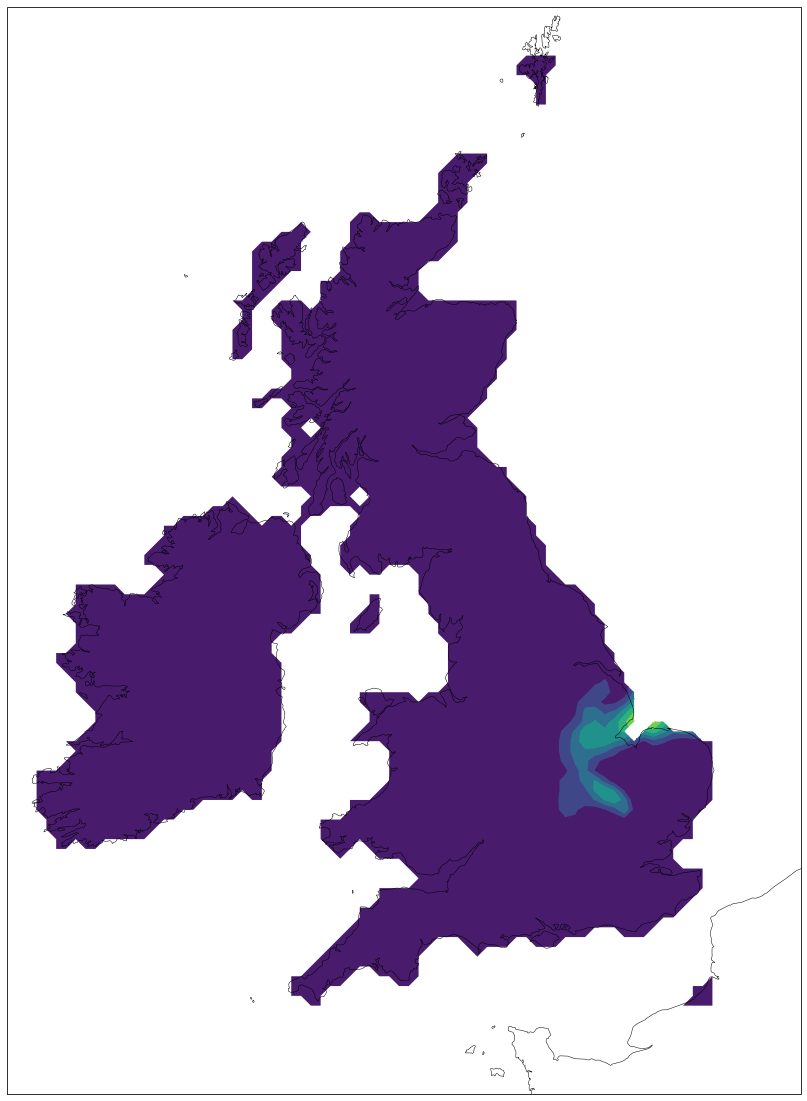

In [42]:
### Check the mask
fig,ax=plt.subplots(figsize=(20,20))
iplt.contourf(test[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

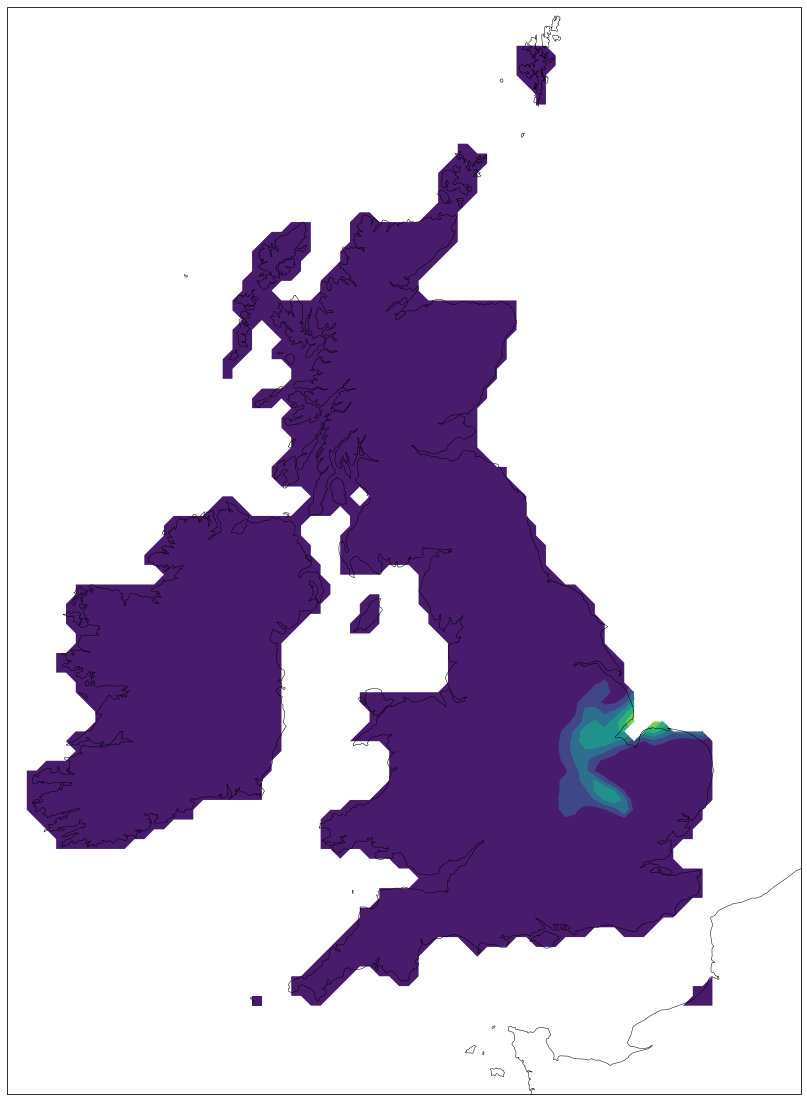

In [40]:
### Check the mask
fig,ax=plt.subplots(figsize=(20,20))
iplt.contourf(cube_2km_bng_masked_regridded_12km[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

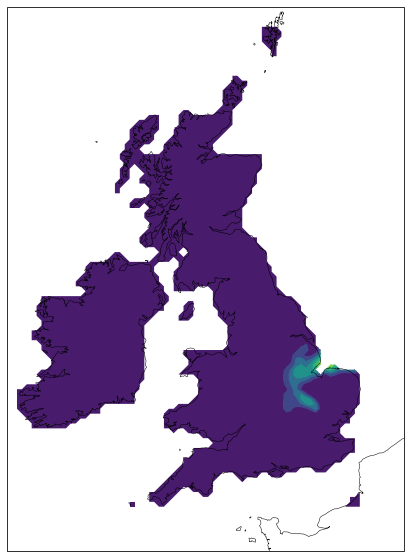

In [28]:
### Check the mask
fig,ax=plt.subplots(figsize=(10,10))
iplt.contourf(cube_2km_bng_masked_regridded_12km[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

# Option 2 - convert to BNG, mask using outline of GB, regrid to 12km

### Convert to BNG

In [ ]:
cube_2km_bng, lats_bng, lons_bng = convert_rotatedpol_to_bng(cube_2km.copy())

### Mask using the outline of GB

In [ ]:
cube_2km_bng_masked = mask_cube(cube_2km_bng, gb_mask_2km)

### Regrid to 12km

In [ ]:
cube_2km_bng_masked_regridded = cube_2km_bng_masked.regrid(cube_12km, iris.analysis.AreaWeighted()) 

### Check plotting

In [ ]:
### Check the mask
fig,ax=plt.subplots(figsize=(10,10))
iplt.contourf(cube_2km_bng_masked_regridded[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

# Option 3: convert to BNG, regrid to 12km, mask

### Convert to BNG

In [29]:
cube_2km_bng, lats_bng, lons_bng = convert_rotatedpol_to_bng(cube_2km.copy())

### Regrid to 12km

In [30]:
cube_2km_bng_regridded_12km = cube_2km_bng.regrid(cube_12km, iris.analysis.AreaWeighted()) 

### Mask using the outline of GB

In [32]:
# cube_2km_bng_regridded_12km_masked = mask_cube(cube_2km_bng_regridded_12km, gb_mask_12km)

### Check plotting

In [ ]:
### Check the mask
fig,ax=plt.subplots(figsize=(10,10))
iplt.contourf(cube_2km_bng_regridded_masked[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Plot alongside original

In [ ]:
# Create a figure
fig = plt.figure(figsize=(15, 10))

# Create the first subplot with one projection
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('WGS84')
ax1.contourf(lons_wgs84, lats_wgs84, cube_2km_wgs84.data[10,:,:], transform=ccrs.PlateCarree(), shading='auto')
gl = ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.OSGB())
ax2.coastlines()
ax2.set_title('BNG')
ax2.contourf(lons_bng, lats_bng, cube_2km_bng.data[100,:,:], transform=ccrs.OSGB(), shading='auto')

# Plot in rotated pole
lats = cube_2km.coord('grid_longitude').points
lons = cube_2km.coord('grid_latitude').points
xx,yy=np.meshgrid(lats, lons)
lats_flat= xx.flatten()
lons_flat = yy.flatten()
ax3 = fig.add_subplot(1, 3, 3, projection=rotated_pole_crs2)
ax3.coastlines()
ax3.set_title('Rotated Pole')
ax3.contourf(xx, yy, cube_2km.data[10,:,:], transform=rotated_pole_crs2, shading='auto');
# gl = ax3.gridlines(draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False

In [ ]:
cube_2km_bng_masked = mask_cube(cube_2km_bng.copy(), gb_mask_2km)
cube_2km_masked = mask_cube(cube_2km.copy(), gb_mask_2km)

In [ ]:
masked_cube_noireland = mask_cube(masked_cube.copy(), gb_mask_2km)

In [ ]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.OSGB())
lats = masked_cube.coord('projection_y_coordinate').points
lons = masked_cube.coord('projection_x_coordinate').points
xx,yy=np.meshgrid(lons, lats)
ax1.coastlines()
ax1.set_title('Masked with LSM')
ax1.contourf(xx, yy, masked_cube.data[10,:,:], transform=ccrs.OSGB(), shading='auto');

# Create the first subplot with one projection
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.OSGB())
ax2.coastlines()
ax2.set_title('BNG')
lats = cube_2km_bng_masked.coord('projection_y_coordinate').points
lons = cube_2km_bng_masked.coord('projection_x_coordinate').points
xx,yy=np.meshgrid(lons, lats)
ax2.contourf(lons, lats, cube_2km_bng_masked.data[10,:,:], transform=ccrs.OSGB(), shading='auto')

# Create the first subplot with one projection
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.OSGB())
ax3.coastlines()
ax3.set_title('BNG')
lats = masked_cube_noireland.coord('projection_y_coordinate').points
lons = masked_cube_noireland.coord('projection_x_coordinate').points
xx,yy=np.meshgrid(lons, lats)
ax3.contourf(lons, lats, masked_cube_noireland.data[10,:,:], transform=ccrs.OSGB(), shading='auto')

## Regrid to 12km and then mask

In [ ]:
cube_2km_bng_regridded_12km = cube_2km_bng.regrid(cube_12km, iris.analysis.AreaWeighted()) 

In [ ]:
### Check the mask
fig,ax=plt.subplots(figsize=(5,5))
iplt.contourf(cube_2km_bng_regridded_12km[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [ ]:
cube_2km_bng_regridded_12km_masked = mask_cube(cube_2km_bng_regridded_12km, gb_mask_12km)

In [ ]:
# fig,ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.OSGB()})
# iplt.contourf(cube_2km_bng_regridded_12km[10])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

## Mask and then regrid to 12km

In [ ]:
cube_2km_bng_masked = mask_cube(cube_2km_bng, gb_mask_2km)
cube_2km_bng_regridded_12km = cube_2km_bng_masked.regrid(cube_12km, iris.analysis.AreaWeighted()) 

### This is a bit un aligned compared to the matplotlib plot - is this to do with not being able to specidy a projection for coastlines?

In [ ]:
# ### Check the mask 
# fig,ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.OSGB()})
# iplt.contourf(cube_2km_bng_masked[10])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [ ]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())

# Create the first subplot with one projection
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.OSGB())
ax2.coastlines()
ax2.set_title('Masked and then Regridded')
lats_bng = cube_2km_bng_regridded_12km.coord('projection_y_coordinate').points
lons_bng = cube_2km_bng_regridded_12km.coord('projection_x_coordinate').points
lons_bng, lats_bng= np.meshgrid(lons_bng, lats_bng)
ax2.contourf(lons_bng, lats_bng, cube_2km_bng_regridded_12km.data[10,:,:], transform=ccrs.OSGB(), shading='auto')

# Plot in rotated pole
lats_bng = cube_2km_bng_regridded_12km_masked.coord('projection_y_coordinate').points
lons_bng = cube_2km_bng_regridded_12km_masked.coord('projection_x_coordinate').points
lons_bng, lats_bng= np.meshgrid(lons_bng, lats_bng)
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.OSGB())
ax3.coastlines()
ax3.set_title('Regridded and then masked')
ax3.contourf(lons_bng, lats_bng, cube_2km_bng_regridded_12km_masked.data[10,:,:], shading='auto');


## Regrid to 12km

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))
# iplt.contourf(cube_2km_bng_regridded_12km[100,:,:])
# # iplt.pcolormesh(cube_bng[100,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))
# iplt.contourf(cube_12km[100,:,:])
# # iplt.pcolormesh(cube_bng[100,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);